In [1]:
import numpy as np
import scipy.stats as sps
from IPython.core.debugger import Tracer
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
sns.set(style='ticks', font='sans-serif')
from matplotlib.ticker import FormatStrFormatter
from matplotlib.collections import LineCollection

import plotly
import plotly.graph_objs as go
import plotly.offline as plo
plotly.offline.init_notebook_mode(connected=True)

import scipy.interpolate as spi

import ipywidgets as widgets

import pickle

import signatures as sg

import joblib as jl


def caption_letter(axis, letter, prop_above=0.1, prop_left=0.1):
    yl = axis.get_ylim()
    xl = axis.get_xlim()
    axis.text(xl[0]-prop_left*np.diff(xl), yl[1]+prop_above*np.diff(yl), letter, horizontalalignment='right', fontsize=18, fontweight='bold')

sns.set_context('notebook', font_scale=1.3)
cat1_color = [.8047, .3125, .3398]
cat2_color = [.4766, .7344, .793]



## Section 1. Confidence divergence

In [2]:
def mix_white(color, x=.5):
    return (1-x)*np.array(color)+x

def plot_divergence_panel(ax, data, nBins=100, Bayes=True, xlabel=True, ylabel=True, absolute=True, cat=None, fade_below_prop=.3):
    if cat is None:
        idx = data['C']<100 # just get index of everything
    else:
        idx = data['C']==cat
    
    if Bayes:
        conf = data['conf']
        label = 'Bayesian confidence'# $p(C=\hat{C} \mid x)$'
    else:
        conf = abs(data['x'])
        label = 'measurement magnitude $|x|$'
    
    colors=np.array([[235,51,139], [37,132,8]])/255.0 # red, green
    labels=['incorrect', 'correct']
            
    for j, correctness in enumerate([False, True]):
        correctness_index = (data['correctness']==correctness) & idx

        s = data['s'][correctness_index]
        if absolute:
            s = abs(data['s'][correctness_index])

        means, edges = sps.binned_statistic(s, conf[correctness_index], statistic=np.mean, bins=nBins)[0:2]
        
        counts = np.histogram(s, edges)[0]
        max_count_for_white_mixing = max(counts)*fade_below_prop
        white_mix_frac = np.around(np.maximum(0, (max_count_for_white_mixing - counts)/max_count_for_white_mixing), decimals=3)
        faded_colors = mix_white(np.tile(colors[j], (len(counts), 1)), white_mix_frac[:,np.newaxis])

        centers = edges[0:-1]+np.diff(edges)/2
        xy=np.concatenate((centers[:,np.newaxis], means[:, np.newaxis]), axis=1).reshape(-1,1,2)
        segments = np.hstack([xy[:-1], xy[1:]])

        collection = LineCollection(segments, color=faded_colors)

        ax.add_collection(collection)
        
#         centers = edges[0:-1]+np.diff(edges)/2
#         ax.plot(centers, means, color=colors[j], label=labels[j])
        
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    sns.despine()
    
    
    if xlabel:
        ax.set_xlabel('stimulus magnitude $|s|$')
    else:
        ax.set_xticklabels('')
        
    if ylabel:
        ax.set_ylabel(label)
    else:
        ax.set_yticklabels('')    

def make_heatmap(slopes, SDs, cat_params, ax, xticks=np.arange(0,3,.5), yticks=np.arange(0,3,.5)):

    sns.heatmap(slopes, ax=ax, center=0, vmin=-.2, vmax=.2, cmap=sns.diverging_palette(70, 275, s=55, l=65, as_cmap=True),
                linecolor=None, rasterized=False, square=True, xticklabels=SDs, yticklabels=cat_params, cbar=False)

    ax.set_xticklabels(xticks)
    ax.set_xticks(np.interp(xticks, SDs, range(len(SDs))))
    
    ax.set_yticklabels(yticks)
    ax.set_yticks(len(cat_params)-np.interp(yticks, cat_params, range(len(cat_params))))

    ax.invert_yaxis()
    
    return ax

In [6]:
slopes_u, slopes_g = pickle.load(open('slopes.p'))

In [13]:
SDs_u = np.linspace(0, 1.8, 32)
SDs_g = np.linspace(0, 3, 32)
cat_params_u = np.linspace(0, 2.5, 32)
cat_params_g = np.linspace(0.3, 2, 32)

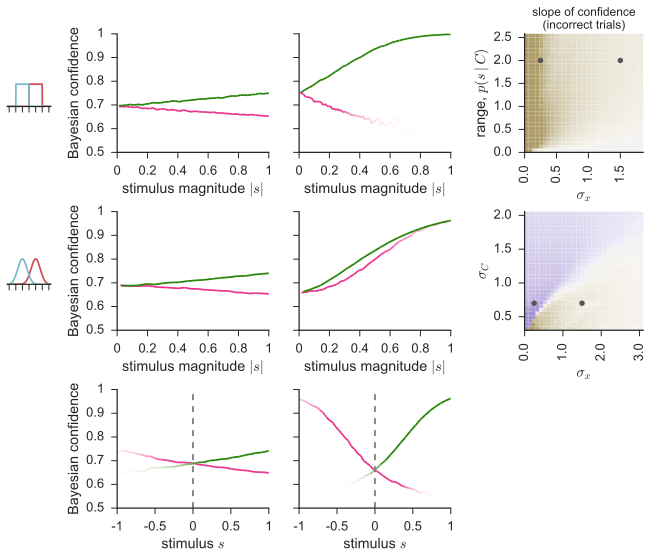

In [16]:
unif_range = 2
xl = [0,1]
yl = [.5,1]
distxl=[-3.3,3.3]
lo_SD = .25
hi_SD = 1.5
nBins = 80



nTrials = int(1e6) # 2e6
fig, ax = plt.subplots(3,4, figsize=(12.5,8.5))
plt.subplots_adjust(wspace=.2, hspace=.5)

lshift = .08 # move left point # the higher the less wide
lshift_mult = -1.5*lshift # change width
hshift = .075 # height

s = np.linspace(distxl[0],distxl[1],500)

#### ROW 1 ##########

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range)
ax[0][0].plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
ax[0][0].plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='cat. 2')
ax[0][0].set_xlim(distxl)
ax[0][0].set_ylim([0,.6])
ax[0][0].set_yticks([])
ax[0][0].set_xticklabels('')
# ax[0][0].legend()
apos = ax[0][0].get_position()
ax[0][0].set_position(np.array(apos.bounds)+[lshift,hshift,lshift_mult,-2*hshift])


data = sg.experiment(type='uniform', nTrials=nTrials, unif_overlap=0, meas_SD=hi_SD, unif_range=unif_range)
plot_divergence_panel(ax[0][1], data, nBins=nBins)
ax[0][1].set_ylim(yl)
ax[0][1].set_xlim(xl)
# ax[0][1].legend(loc='upper left')

data = sg.experiment(type='uniform', nTrials=nTrials, unif_overlap=0, meas_SD=lo_SD, unif_range=unif_range)
plot_divergence_panel(ax[0][2], data, ylabel=False, nBins=nBins)
ax[0][2].set_xlim(xl)
ax[0][2].set_ylim(yl)

make_heatmap(slopes_u.T, SDs_u, cat_params_u, ax[0][3], xticks=np.arange(0,1.6,.5), yticks=np.arange(0,2.6,.5))
apos = ax[0][3].get_position()
ax[0][3].set_position(np.array(apos.bounds)+[.03,0,0,0])
ax[0][3].set_ylabel('range, $p(s \mid C)$')
ax[0][3].set_xlabel('$\sigma_x$')
ax[0][3].set_title('slope of confidence\n(incorrect trials)', size=12)
ax[0][3].plot(np.interp([hi_SD, lo_SD], SDs_u, range(len(SDs_u))), len(cat_params_u)-np.interp([2,2], cat_params_u, range(len(cat_params_u))), '.', color='#555555', markersize=11)

#### ROWS 2 and 3 #######

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', unif_range=unif_range, norm_mean=1, norm_SD=.7)
ax[1][0].plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
ax[1][0].plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='cat. 2')
ax[1][0].set_xlim(distxl)
ax[1][0].set_ylim([0,.6])
ax[1][0].set_yticks([])
ax[1][0].set_xticklabels('')
# ax[1][0].legend()
apos = ax[1][0].get_position()
ax[1][0].set_position(np.array(apos.bounds)+[lshift,hshift,lshift_mult,-2*hshift])


data = sg.experiment(type='gaussian', nTrials=nTrials, norm_mean=1, norm_SD=.7, meas_SD=hi_SD, unif_range=unif_range)
plot_divergence_panel(ax[1][1], data, nBins=nBins)
ax[1][1].set_xlim(xl)
ax[1][1].set_ylim(yl)

plot_divergence_panel(ax[2][1], data, absolute=False, cat=1, nBins=nBins)
ax[2][1].set_xlim([-xl[1], xl[1]])
ax[2][1].set_ylim(yl)
ax[2][1].set_xlabel('stimulus $s$')
ax[2][1].axvline(0, color='#777777', linestyle='--')

data = sg.experiment(type='gaussian', nTrials=nTrials, norm_mean=1, norm_SD=.7, meas_SD=lo_SD, unif_range=unif_range)
plot_divergence_panel(ax[1][2], data, ylabel=False, nBins=nBins)
ax[1][2].set_xlim(xl)
ax[1][2].set_ylim(yl)

make_heatmap(slopes_g.T, SDs_g, cat_params_g, ax[1][3], yticks=np.arange(.5,2.1,.5), xticks=np.arange(0,3.1,1))
apos = ax[1][3].get_position()
ax[1][3].set_position(np.array(apos.bounds)+[.03,0,0,0])
ax[1][3].set_ylabel('$\sigma_C$')
ax[1][3].set_xlabel('$\sigma_x$')
# ax[1][3].set_title('slope of confidence\n(incorrect trials)', size=12)
ax[1][3].plot(np.interp([hi_SD, lo_SD], SDs_g, range(len(SDs_g))), len(cat_params_g)-np.interp([.7,.7], cat_params_g, range(len(cat_params_g))), '.', color='#555555', markersize=11)


plot_divergence_panel(ax[2][2], data, ylabel=False, absolute=False, cat=1, nBins=nBins)
ax[2][2].set_xlim([-xl[1], xl[1]])
ax[2][2].set_ylim(yl)
ax[2][2].set_xlabel('stimulus $s$')
ax[2][2].axvline(0, color='#777777', linestyle='--')

ax[2][0].remove()
# ax[2][0].plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
# ax[2][0].plot(s, stimdist_n1.pdf(s), '-', color=mix_white(cat2_color, .75), label='cat. 2')
# ax[2][0].set_xlim(distxl)
# ax[2][0].set_ylim([0,.6])
# ax[2][0].set_yticks([])
# ax[2][0].set_xticklabels('')
# apos = ax[2][0].get_position()
# ax[2][0].set_position(np.array(apos.bounds)+[lshift,hshift,-1.3*lshift,-2*hshift])
# sns.despine(ax=ax[2][0], left=True)
sns.despine(ax=ax[1][0], left=True)
sns.despine(ax=ax[0][0], left=True)

ax[2][3].remove()

# fig.savefig('fig2_heatmap.pdf')

In [13]:
def get_slope(cat_param, type, nTrials, SD):
    if type=='uniform':
        data = sg.experiment(type=type, nTrials=int(nTrials), meas_SD=SD, unif_range=cat_param)
    else:
        data = sg.experiment(type=type, nTrials=int(nTrials), meas_SD=SD, norm_mean=1, norm_SD=cat_param)

    if data['correctness'].all():
        slope=np.nan
    else:
        false_index = ~data['correctness']
        means, edges = sps.binned_statistic(abs(data['s'][false_index]), data['conf'][false_index], statistic=np.mean, bins=nBins)[:2]

        centers = edges[0:-1]+np.diff(edges)/2

        if np.isnan(means).all():
            slope = np.nan
        else:
            idx = (means==means) & (centers==centers)
            slope = sps.linregress(centers[idx], means[idx])[0] # (np.diff(means[~np.isnan(means)][[0,-1]]) # diff of first and last non-nan

    return slope


def incorrect_slopes(type='uniform', SDs=np.linspace(0.01,2,8), cat_params=np.linspace(0.01,2,7), nTrials=5e5, nBins=30):
    # have this make a full list and feed that to Parallel rather than reinstancing Parallel so many times
    
    num_cores = 8
    
    n_cat_params = len(cat_params)
    
    slopes = np.empty((len(SDs), n_cat_params))

    for i, SD in enumerate(SDs):
        slopes[i] = jl.Parallel(n_jobs=num_cores)(jl.delayed(get_slope)(cat_param, type=type, nTrials=nTrials, SD=SD) for cat_param in cat_params)
        
    return slopes

In [ ]:
# recompute slopes
slopes_u = incorrect_slopes(SDs=SDs_u, cat_params=cat_params_u)
slopes_g = incorrect_slopes(SDs=SDs_g, cat_params=cat_params_g, type='gaussian')

In [14]:
def plot_slopes_3d(SDs, cat_params, slopes, points=np.array([[0,0,0],[1,1,1]]), type='uniform'):
    if type == 'uniform':
        xtitle = 'unif. range'
    else:
        xtitle = 'sig_C'
    
#     interpolator = spi.interp2d(SDs, cat_params, slopes_u)
#     z_points = np.array([interpolator(x=i[0], y=i[1])[0] for i in points])
    
    data = [
        go.Surface(x=cat_params,
                   y=SDs,
                   z=slopes,
                   cmin=-.2,
                   cmax=.2),
        go.Surface(x=cat_params,
                   y=SDs,
                   z=0*slopes,
                   opacity=0.8),
        go.Scatter3d(x=points[:,0],
                     y=points[:,1],
                     z=points[:,2],#z_points+.03,
                     mode='markers',
                     marker=dict(size=6, color='black', opacity=.8))
    ]

    layout = go.Layout(
        scene=dict(
            zaxis=dict(
                title='confidence slope (incorrect trials)',
                range=[-.2,.2]),
            yaxis=dict(
                title='$\sigma$',
                range=[0,max(SDs)]),
            xaxis=dict(title=xtitle,
                       range=[0,max(cat_params)]),
            aspectratio=dict(x=1,y=1,z=1),
            camera=dict(eye=dict(x=-2,y=-2,z=1))),
        font=dict(family='Helvetica')
    )

    fig = go.Figure(data=data, layout=layout)
    plo.iplot(fig)
    

## Section 2. Mean confidence at neutral evidence

In [155]:
sig_C = 1
sigratio = np.linspace(np.finfo(float).eps,2,40)
unif_range = 2
SD = sigratio*unif_range
unif_overlap = np.linspace(0, unif_range/2, 40)

nTrials = 4e4 # 4e4

meanconf = np.empty((len(SD), len(unif_overlap)))

for i, overlap in enumerate(unif_overlap):
    for j, meas_SD in enumerate(SD):
        meanconf[i, j] = sg.meanconf_sim(type='uniform',
                                         meas_SD=meas_SD,
                                         unif_overlap=overlap,
                                         unif_range=unif_range,
                                         nTrials=int(nTrials))        

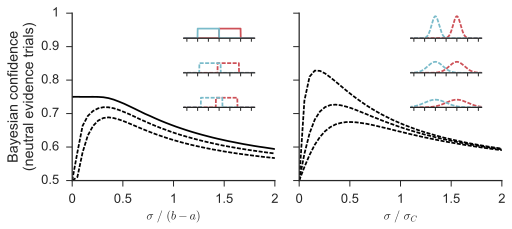

In [172]:
unif_overlaps = [0, .15, .3]
unif_linestyles = ['-', '--', '--']
dashstyle = [4,1.5]
sig_Cs = [0.35, 0.7, 1]
norm_mean = [1,1,1]
nTrials = 1e6 # 4e4


fig, axes = plt.subplots(1, 2, sharey='row', figsize=(7.7,3))
plt.subplots_adjust(wspace=.12, hspace=.5)

out = np.zeros(len(SD))
for j, overlap in enumerate(unif_overlaps):
    for i, meas_SD in enumerate(SD):
        out[i] = sg.meanconf_sim(type='uniform', meas_SD=meas_SD, unif_overlap=overlap, unif_range=unif_range, nTrials=int(nTrials))
    l, = axes[0].plot(sigratio, out, color='k')
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)


axes[0].set_xlabel('$\sigma\ /\ (b-a)$',fontsize=12)
axes[0].set_ylim([.5,1])
axes[0].set_xlim([0,2])
axes[0].set_ylabel('Bayesian confidence\n(neutral evidence trials)')
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
apos = axes[0].get_position()

x = [apos.x0, apos.x1]
y = [apos.y0, apos.y1]
sns.despine(ax=axes[0])

#### INSETS ##########
LWYHM = [.55, .35, .85, .15, 0.16] # L point, width, Y point, height, margin
ylim = [0,1.3]
s = np.linspace(-4,4,500)
for j, overlap in enumerate(unif_overlaps):
    ax = plt.axes([float(x[0]+np.diff(x)*LWYHM[0]), float(y[0]+np.diff(y)*LWYHM[2])-LWYHM[4]*j, float(np.diff(x)*LWYHM[1]), float(np.diff(y)*LWYHM[3])])
    stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range, unif_overlap=overlap)
    l,=ax.plot(s, stimdist_1.pdf(s), '-', color=cat1_color)
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)
    l,=ax.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color)
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)
    
    ax.set_yticks([])
    ax.set_xticks(np.linspace(-3,3,7))
    ax.set_xlim([-3.3,3.3])
    ax.set_xticklabels([])
    ax.set_ylim(ylim)
    ax.tick_params(length=3.5)
    sns.despine(ax=ax, left=True)
    
    
for j, sig_C in enumerate(sig_Cs):
    for i, meas_SD in enumerate(SD):
        out[i] = sg.meanconf_sim(type='gaussian', meas_SD=meas_SD, norm_mean=norm_mean[j], norm_SD=sig_C, nTrials=int(nTrials))
    l,=axes[1].plot(sigratio, out, '--', color='k')
    l.set_dashes(dashstyle)


axes[1].set_xlabel('$\sigma\ /\ \sigma_C$',fontsize=12)
axes[1].set_ylim([.5,1])
axes[1].set_xlim([0,2])
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
apos = axes[1].get_position()

x = [apos.x0, apos.x1]
y = [apos.y0, apos.y1]
sns.despine(ax=axes[1])

#### INSETS ##########
s = np.linspace(-4,4,500)
for j, sig_C in enumerate(sig_Cs):
    ax = plt.axes([float(x[0]+np.diff(x)*LWYHM[0]), float(y[0]+np.diff(y)*LWYHM[2])-LWYHM[4]*j, float(np.diff(x)*LWYHM[1]), float(np.diff(y)*LWYHM[3])])
    stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', norm_mean=norm_mean[j], norm_SD=sig_C)
    l,=ax.plot(s, stimdist_1.pdf(s), '-', color=cat1_color)
    l.set_dashes(dashstyle)
    l,=ax.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color)
    l.set_dashes(dashstyle)

    ax.set_yticks([])
    ax.set_xticks(np.linspace(-3,3,7))
    ax.set_xlim([-3.3,3.3])
    ax.set_ylim(ylim)
    ax.set_xticklabels([])
    ax.tick_params(length=3.5)
    sns.despine(ax=ax, left=True)
    
fig.savefig('fig3_tmp.pdf', bbox_inches='tight')